In [1]:
# Author : https://github.com/boguss1225
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import config

os.environ["CUDA_VISIBLE_DEVICES"]="1"
# Colour Template (RGB)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
CYAN = (0, 255, 255)
MAGENTA = (255, 0, 255)
YELLOW = (255, 255, 0)

2023-01-08 11:39:01.688964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 11:39:02.523042: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mirap/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-01-08 11:39:02.523109: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mirap/.local/lib/

In [2]:
# TO BE CONFIGURED
PATCH_SIZE_W, PATCH_SIZE_H = 128, 128
FILE_PATH = "/home/mirap/0_DATABASE/IMAS_Salmon/2_Salmon_High_Quality_CVAT/train_images/untitled-368.jpg"
image_size = config.image_width, config.image_height

class_colour = {0:RED, 1:GREEN, 2:BLUE, 3:CYAN, 4:MAGENTA, 5:YELLOW}

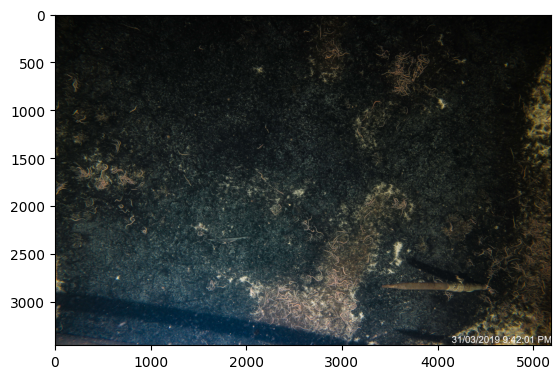

In [3]:
# Check image
img = mpimg.imread(FILE_PATH)
imgplot = plt.imshow(img)
plt.show()

In [4]:
"""
## Load model from h5
"""
model = tf.keras.models.load_model(config.model_dir+config.model_save_name+".h5")
print("load model successful")
# keras.utils.plot_model(model, show_shapes=True)

2023-01-08 11:39:05.681850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 11:39:06.170690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24964 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


load model successful


In [5]:
# Load image
im = cv2.imread(FILE_PATH)
# im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
img_h, img_w, img_c = im.shape
print('width:  ', img_w)
print('height: ', img_h)
print('channel:', img_c)

width:   5184
height:  3456
channel: 3


In [6]:
# Initialize blank mask image of same dimensions for drawing the shapes
bg = np.zeros_like(im, np.uint8)

In [7]:
w_ratio = int(img_w/PATCH_SIZE_W)
h_ratio = int(img_h/PATCH_SIZE_H)

In [8]:
import numpy as np
def test_single_image(img_dir, model):
    img_raw = tf.io.read_file(img_dir)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=config.channels)
    img_tensor = tf.image.resize(img_tensor, [config.image_height, config.image_width])

    img_numpy = img_tensor.numpy()
    img_numpy = (np.expand_dims(img_numpy, 0))
    img_tensor = tf.convert_to_tensor(img_numpy, tf.float32)

#     img_tensor = img_tensor / 255.0 # uncomment if model included rescale preprocessing layer
    prob = model(tf.image.resize(img_tensor,[config.image_width,config.image_height]))

    
    
    # 'if not sure go to background' implementation
    precision_threshold = 0.5
    if np.max(prob) < precision_threshold :
        classification = 5
    else :
        classification = np.argmax(prob)
    return classification

In [9]:
# iterate image upon patch size
for h in range(h_ratio) :
    y_min = h * PATCH_SIZE_H
    y_max = y_min + PATCH_SIZE_H
    
    for w in range(w_ratio) : 
        x_min = w * PATCH_SIZE_W
        x_max = x_min + PATCH_SIZE_W
        
        # Cropping image
        cropped_image = im[y_min:y_max,x_min:x_max]
        cv2.imwrite("temp_cropped.jpg", cropped_image)
        
        # Classify cropped image
        classfication_result = test_single_image("temp_cropped.jpg", model)
        
        # overlay colour on image 
        cv2.rectangle(bg, (x_min, y_min), (x_max, y_max), class_colour[classfication_result] ,cv2.FILLED)

2023-01-08 11:39:09.638730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-01-08 11:39:10.230718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [10]:
# Generate output by blending image with bg image, using the bg
# images also as mask to limit the blending to those parts
out = im.copy()
alpha = 0.5 # transparant (highest : 1.0, lowest : 0)
mask = bg.astype(bool)
out[mask] = cv2.addWeighted(im, alpha, bg, 1 - alpha, 0)[mask]

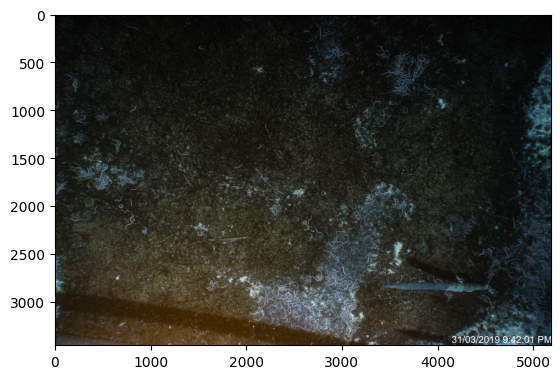

In [11]:
plt.imshow(im)

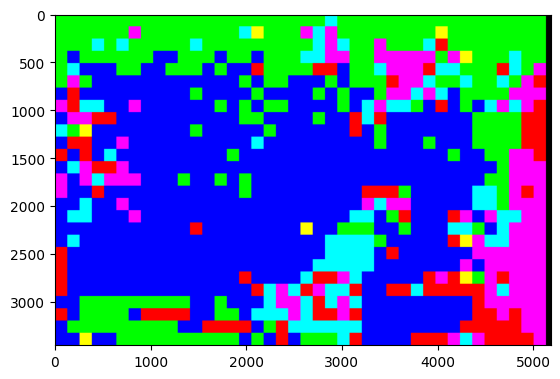

In [12]:
plt.imshow(bg)

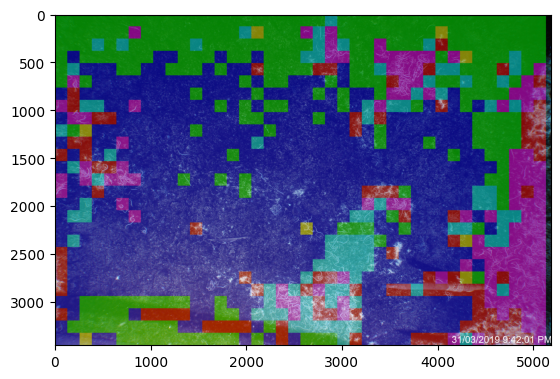

In [13]:
plt.imshow(out)